# Convolutional Neural Network and Adversarial Attacks

En el siguiente código se crea una red neuronal convolucional que identifica dígitos escritos a mano para posteriormente engañarla usando un white box adversarial attack conocido como FGSM

# Importaciones

In [60]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from random import randrange

# Dataset

A continuación descargamos el dataset

In [2]:
#  Cargamos el dataset y lo dividimos en entrenamiento y entreno
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Importante: normalizar los píxeles entre 0 y 1. También se puede usar el método normalize
train_images, test_images = train_images / 255.0, test_images / 255.0

## Comprobamos el formato

Elegimos una imagen y mostramos su imagen y su etiqueta

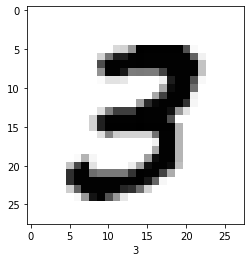

In [3]:
num_imagen = 7  

plt.imshow(train_images[num_imagen] ,cmap=plt.cm.binary)
plt.xlabel(train_labels[num_imagen])
plt.show()

## Reshape
La red espera una entrada de la forma (60000, 28, 28, 1), de forma que tenemos que modificar la entrada a eso

In [4]:
train_images = train_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

# Definición de la red

In [5]:
# Creamos un modelo secuencial, es decir, la información fluirá de izquierda a derecha
model = models.Sequential()

# Añadimos las capas convolucionaes
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Y posteriormente, las pasamos a capas lineales
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) # Que escojamos 64 neuronas no tiene nada que ver con lo anterior
model.add(layers.Dense(10, activation='softmax'))

# Echemos un vistazo a cómo nos queda la red
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Creación de la red

In [6]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Entrenamiento de la red

In [7]:
entrenamiento = model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 8s 137us/sample - loss: 0.1448 - accuracy: 0.9560 - val_loss: 0.0613 - val_accuracy: 0.97940s - loss: 0.1538 
Epoch 2/3
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 3/3
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.0321 - val_accuracy: 0.9890


## Análisis de resultados

Comprobamos ahora en función de los datos de pérdida y precisión si sería beneficial aumentar las épocas o no

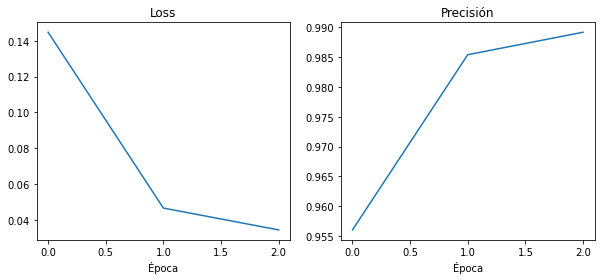

In [49]:
# Mostramos la pérdida y la precisión
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title("Loss")
plt.xlabel("Época")
plt.plot(entrenamiento.history['loss'], label= "Loss")

plt.subplot(122)
plt.title("Precisión")
plt.xlabel("Época")
plt.plot(entrenamiento.history['accuracy'], label= "Precisión")

En base a la gráfica se observa que el valor ideal de épocas es 3 (empezamos en 0)

# Testeo de la red

En este caso, el modelo comprueba en cada época la precisión con los datos de test, de forma que aumenta de forma más rápida la precisión. Es decir, la siguiente parte daría el mismo resultado que la última época de entrenamiento. Esto sólo tendrá sentido cuando metamos el adversarial dataset

In [9]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

10000/10000 [==============================] - 0s 46us/sample - loss: 0.0321 - accuracy: 0.9890


# Predicción de resultados

Comprobamos que las imágenes introducidas corresponden con los valores predichos


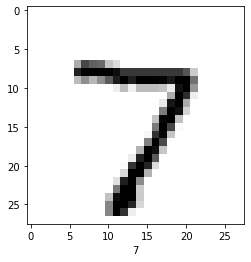

La clase predicha es: 7 con una confianza del 99.99 %


In [10]:
num_imagen = 0

plt.imshow(test_images[num_imagen], cmap=plt.cm.binary)
plt.xlabel(test_labels[num_imagen])
plt.show()

print("La clase predicha es:", np.argmax(model.predict([test_images])[num_imagen]), "con una confianza del", 
      round(np.max(model.predict([test_images])[num_imagen])*100, 2), "%")

# Crear dataset FGSM
### Crear las perturbaciones
Primero calculamos las perturbaciones para el dataset escogido, de forma que podemos realizar el FGSM sobre el test para realizar pruebas o sobre el train para entrenar posteriormente a la red con él

In [16]:
# Introducimos el dataset del que queremos imágenes adversariales, test o train
dataset = "test"

# Definimos un nombre para guardar las perturbaciones sobre dicho dataset
filename = "pert_" + dataset + ".npy"
    
# Primero comprobamos directamente si tenemos ya el dataset requerido, porque tarda bastante en compilar    
try: 
    perturbaciones = np.load(filename, allow_pickle=True)
except:
    # Creamos la perturbacion
    perturbaciones = FGSM(dataset)
    np.save(filename, perturbaciones)

### Creación de las adversarial images
Una vez tenemos las perturbaciones del dataset escogido, lo recorremos para los valores de epsilon deseados obteniendo un vector de predicciones

In [47]:
# Definimos los valores de epsilon para los que queremos crear el dataset. Ojo, si queremos el dataset de entrenamiento
# mejor poner sólo un valor de epsilon, poque tarda mucho
epsilon = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

# Creamos nueustro vector de predicciones si usamos el dataset de test
if dataset == "test":
    try: 
        filename = "predicciones_" + str(epsilon) + ".npy"
        predicciones = np.load(filename, allow_pickle = True)
        
    except: 
        # Creamos nuestro vector vacío con las predicciones
        predicciones = np.empty([len(epsilon), 10000, 10])
            
        # Recorremos los datasets para cada uno de esos valores de epsilon    
        for i in range(len(epsilon)):
            # Creamos el adversarial dataset
            adversarial_dataset = creacion_adversarial_dataset(epsilon[i], dataset, perturbaciones)   

            # Calculamos las métricas
            prediccion = model.predict([adversarial_dataset])
            predicciones[i] = prediccion

        # Guardamos los resultados porque tarda bastante en compilar
        np.save(filename, predicciones)
else:
    try: 
        filename = "train" + str(epsilon[i]) + ".npy"
        adversarial_trainset = np.load(filename, allow_pickle = True)
        
    except:
        # Creamos un vector vacío de las dimensiones adecuadas
        adversarial_dataset = np.empty([len(epsilon), 60000, 28, 28, 1])
        
        # Recorremos los datasets para cada uno de esos valores de epsilon    
        for i in range(len(epsilon)):
            # Creamos el adversarial dataset
            adversarial_trainset_epsilon = creacion_adversarial_dataset(epsilon[i], dataset, perturbaciones)   
            
            # Metemos el resultado en el vector gordo
            adversarial_trainset[i] = adversarial_trainset_epsilon
        
        # Y guardamos el resultado
        np.save(filename, adversarial_trainset)

### Comprobación de que se han creado correctamente

La forma del vector predicciones es: (7, 10000, 10)
La predicción es: 0 con una confianza del 97.00000286102295 %


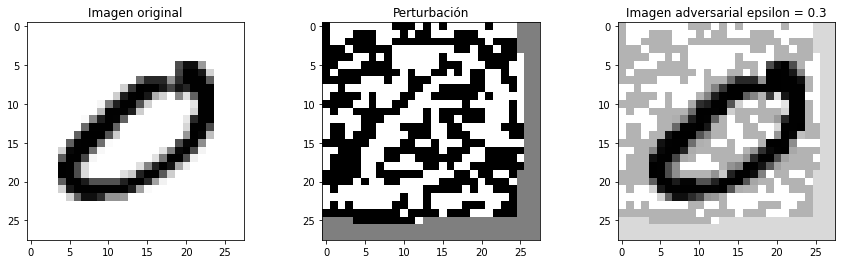

In [70]:
if dataset == "test":
    # Mostramos la forma
    print("La forma del vector predicciones es:", predicciones.shape)
    
    # Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
    num_imagen = randrange(10000)
    valor = randrange(len(epsilon))
    
    imagen_original = test_images[num_imagen]
    perturbacion = perturbaciones[num_imagen] * 0.5 + 0.5
    imagen = imagen_original + epsilon[valor] * perturbacion
    imagen = tf.clip_by_value(imagen, -1, 1)
    
    # Llamamos a la función de impresión
    impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon[valor])
    prediccion_adversarial(imagen)
    
    
else:
    # Mostramos la forma
    print("La forma del vector trainset adversarial es:", perturbaciones.shape)
    
    # Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
    num_imagen = randrange(60000)
    valor = randrange(len(epsilon))
    
    imagen_original = train_images[num_imagen]
    perturbacion = perturbaciones[num_imagen] * 0.5 + 0.5
    imagen = imagen_original + epsilon[valor] * perturbacion
    imagen = tf.clip_by_value(imagen, -1, 1)
    
    # Llamamos a la función de impresión
    impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon[valor])
    prediccion_adversarial(imagen)

# Análisis de métricas

Para epsilon = 0.01: Aciertos = 9873, Fallos = 127 luego Precisión = 98.73 % con una confianza media del 98.93 %
Para epsilon = 0.05: Aciertos = 9743, Fallos = 257 luego Precisión = 97.43 % con una confianza media del 98.07 %
Para epsilon = 0.1: Aciertos = 9490, Fallos = 510 luego Precisión = 94.90 % con una confianza media del 96.42 %
Para epsilon = 0.15: Aciertos = 9063, Fallos = 937 luego Precisión = 90.63 % con una confianza media del 94.00 %
Para epsilon = 0.2: Aciertos = 8391, Fallos = 1609 luego Precisión = 83.91 % con una confianza media del 90.98 %
Para epsilon = 0.25: Aciertos = 7624, Fallos = 2376 luego Precisión = 76.24 % con una confianza media del 87.18 %
Para epsilon = 0.3: Aciertos = 6552, Fallos = 3448 luego Precisión = 65.52 % con una confianza media del 83.00 %


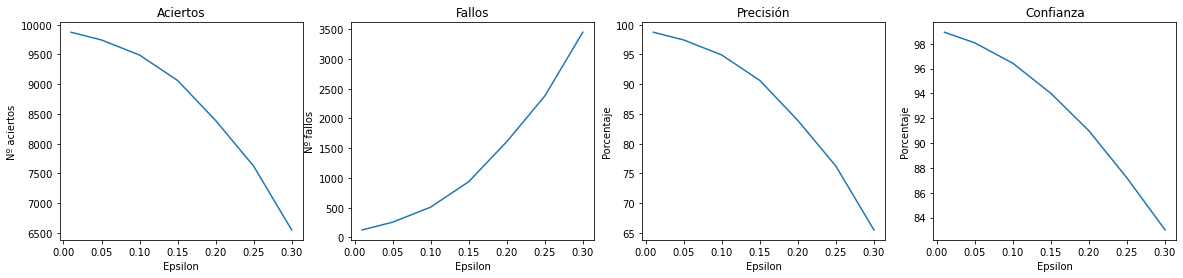

In [58]:
# Creamos los vectores globales
aciertos_epsilon = np.empty(len(epsilon)) 
fallos_epsilon = np.empty(len(epsilon))
precisiones = np.empty(len(epsilon))
confianzas = np.empty(len(epsilon)) 

# Recorremos los epsilons
for i in range(len(epsilon)):
    aciertos = 0
    confianza = 0
    
    # Recorremos las predicciones
    for j in range(10000):
        prediccion = np.argmax(predicciones[i][j])
        confianza = confianza + np.max(predicciones[i][j])
        if prediccion == test_labels[j]:
            aciertos += 1
     
    # Calculamos las métricas para cada epsilon
    fallos = 10000 - aciertos
    precision = (aciertos / 10000) * 100
    confianza = (confianza / 10000) * 100
    print("Para epsilon = {}: Aciertos = {}, Fallos = {} luego Precisión = {:0.2f} % con una confianza media del {:0.2f} %"
          . format(epsilon[i], aciertos, fallos, precision, confianza))
    
    # Creamos un vector con todas las métricas para poder realizar gráficas
    aciertos_epsilon[i] = aciertos
    fallos_epsilon[i] = fallos
    precisiones[i] = precision
    confianzas[i] = confianza
    
# Creamos gráficas de los resultados
plt.figure(figsize=(20,4))

plt.subplot(141)
plt.title("Aciertos")
plt.xlabel("Epsilon")
plt.ylabel("Nº aciertos")
plt.plot(epsilon, aciertos_epsilon)

plt.subplot(142)
plt.title("Fallos")
plt.xlabel("Epsilon")
plt.ylabel("Nº fallos")
plt.plot(epsilon, fallos_epsilon)

plt.subplot(143)
plt.title("Precisión")
plt.xlabel("Epsilon")
plt.ylabel("Porcentaje")
plt.plot(epsilon, precisiones)

plt.subplot(144)
plt.title("Confianza")
plt.xlabel("Epsilon")
plt.ylabel("Porcentaje")
plt.plot(epsilon, confianzas)

# Funciones utilizadas

###  Creación de la perturbación

In [12]:
def FGSM(dataset):
    
    # Definimos el dataset a utilizar, si el train o el test
    if dataset == "test":
        dataset = test_images
        labels = test_labels
    else:
        dataset = train_images
        labels = train_labels
    
    # Creamos un vector vacío para almacenar las perturbaciones
    perturbaciones = np.empty([len(dataset), 28, 28, 1])
    
    # Recorremos las imágenes del dataset elegido
    for num_imagen in range(len(dataset)):
        # Expandimos la dimensión
        imagen = dataset[num_imagen]
        imagen = np.expand_dims(imagen, axis = 0)
        label = labels[num_imagen]

        # Convertimos a tensor
        imagen = tf.convert_to_tensor(imagen, dtype = tf.float32)

        # Definimos la función de pérdida
        funcion_loss = tf.keras.losses.SparseCategoricalCrossentropy()

        # Creamos la perturbacion
        def crear_perturbacion(imagen, label):
            with tf.GradientTape() as tape:
                tape.watch(imagen)
                prediccion = model(imagen)
                loss = funcion_loss(label, prediccion)

            gradiente = tape.gradient(loss, imagen)
            signo_grad = tf.sign(gradiente)
            return signo_grad

        # Llamamos a la función
        perturbaciones[num_imagen] = crear_perturbacion(imagen, label)

    return perturbaciones

### Creación del dataset adversarial

In [13]:
def creacion_adversarial_dataset(epsilon, dataset, perturbaciones):
    
     # Definimos el dataset a utilizar, si el train o el test
    if dataset == "test":
        dataset = test_images
        labels = test_labels
    else:
        dataset = train_images
        labels = train_labels
    
    # Creamos el adversarial dataset vacío
    adversarial_dataset = np.empty([len(dataset), 28, 28, 1])
    
    # Recorremos el dataset original y le vamos sumando el vector de perturbaciones creado anteriormente
    for num_imagen in range(len(dataset)):
        adversarial_dataset[num_imagen] = dataset[num_imagen] + epsilon * (perturbaciones[num_imagen] * 0.5 + 0.5)
        adversarial_dataset[num_imagen] = tf.clip_by_value(adversarial_dataset[num_imagen], -1, 1)
    
    return adversarial_dataset

### Impresión del dataset adversarial para cada epsilon

In [65]:
def impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon):
        
    # Imprimimos una imagen con su perturbación y su imagen adversarial resultante
    plt.figure(figsize=(15,4))

    plt.subplot(131)
    plt.title("Imagen original")
    plt.imshow(imagen_original, cmap=plt.cm.binary)

    plt.subplot(132)
    plt.title("Perturbación")
    plt.imshow(perturbacion, cmap=plt.cm.binary)

    plt.subplot(133)
    plt.title("Imagen adversarial epsilon = {}".format(epsilon))
    plt.imshow(imagen, cmap=plt.cm.binary)

### Predicción de una imagen adversarial

In [67]:
def prediccion_adversarial(imagen):
    # Primero expandimos una dimensión
    imagen = np.expand_dims(imagen, axis = 0)
    
    # Y realizamos la predicción
    print("La predicción es:", np.argmax(model.predict(imagen)), "con una confianza del", 
          round(np.max(model.predict(imagen)),2)*100, "%")